In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import libpysal
import spopt
from spopt.region import Skater
from sklearn.metrics import pairwise as skm
from sklearn.cluster import AgglomerativeClustering

C:\Python310\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


#### Model 3: Spatial Constraint Clustering

In [2]:
def WCSS_score (data, cluster_labels):
    import numpy as np
    unique_labels = np.unique(cluster_labels)
    wcss = 0
    for label in unique_labels:
        cluster_points = data[cluster_labels == label]
        centroid = np.mean(cluster_points)
        squared_distances = np.sum((cluster_points - centroid) ** 2)
        wcss += np.sum(squared_distances)
    return wcss

In [3]:
# Geometric data
# source: https://data.humdata.org/dataset/f5f0648e-f085-4c85-8242-26bf6c942f40/resource/2f26be26-a081-4557-8572-58545cd70e9f/download/bra_adm_ibge_2020_shp.zip
import unidecode
gdfState=gpd.read_file('data/bra_adm_ibge_2020_shp/bra_admbnda_adm1_ibge_2020.shp')
gdfState.loc[gdfState['ADM1_PCODE']=='BR32','ADM1_PT']="Esperito Santo"
gdfState['ADM1_PT']=gdfState['ADM1_PT'].apply(unidecode.unidecode)

train=pd.read_csv('data/model_train.csv', index_col=0)
test=pd.read_csv('data/model_test.csv', index_col=0)

folder_name='results/2023-08-24/2023-08-24_'
model_name='1_1_0'
var_name='VehGroup_wtd_'
veh_wtd=pd.read_csv(folder_name+var_name+model_name+'.csv', index_col=0)

var_name='cls_0_wtd_'
cls_wtd=pd.read_csv(folder_name+var_name+model_name+'.csv', index_col=0)

# combine the geometric information, nnet weight for each state (after pre-merged)
gdfState=gdfState.merge(train[['State','cls_0']].drop_duplicates(), left_on='ADM1_PT', right_on='State', how='left')[['geometry','State','cls_0']]
gdfState=gdfState.merge(cls_wtd, on='cls_0')
gdfCls=gdfState.drop(columns=['State']).dissolve(by='cls_0', as_index=False).rename(
    columns={'cls_0_wtd':'State_wtd'})

In [4]:
gdfCls.head()

cls_0                                           geometry  State_wtd
0      Acre  MULTIPOLYGON (((-68.88297 -11.01937, -68.88607...  -0.097149
1   Alagoas  POLYGON ((-35.46317 -8.82467, -35.46457 -8.828...  -0.114044
2  Amazonas  MULTIPOLYGON (((-58.49827 -0.83437, -58.49417 ...  -0.099747
3     Bahia  MULTIPOLYGON (((-38.71177 -17.96617, -38.70687...  -0.120071
4     Ceara  MULTIPOLYGON (((-40.42827 -2.81117, -40.42397 ...  -0.094499

C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


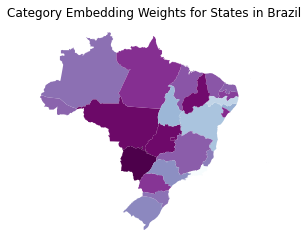

In [5]:
ax = gdfCls.plot(column='State_wtd', cmap='BuPu')
ax.tick_params(left=False, bottom=False)
ax.set(title='Category Embedding Weights for States in Brazil', xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])#, 
sns.despine(left=True, bottom=True, right=True)
plt.show()

In [6]:
gdfCls.explore(column='State_wtd', cmap='BuPu')

In [7]:
# create connectivity matrix
# Rook neighbors are those states that share an edge on their respective borders - more appropriate
# Queen neighbors are based on a more inclusive condition that requires only a shared vertex (point) between two states:
w_rook = libpysal.weights.Rook.from_dataframe(gdfCls)

C:\Python310\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 5.
  warnings.warn(message)


C:\Python310\lib\site-packages\spopt\region\skater.py:537: OptimizeWarning: By default, the graph is disconnected! Counting islands towards the remaining 0 clusters.
  model.fit(
C:\Python310\lib\site-packages\spopt\region\skater.py:537: OptimizeWarning: By default, the graph is disconnected! Counting islands towards the remaining 1 clusters.
  model.fit(
C:\Python310\lib\site-packages\spopt\region\skater.py:537: OptimizeWarning: By default, the graph is disconnected! Counting islands towards the remaining 2 clusters.
  model.fit(
C:\Python310\lib\site-packages\spopt\region\skater.py:537: OptimizeWarning: By default, the graph is disconnected! Counting islands towards the remaining 3 clusters.
  model.fit(
C:\Python310\lib\site-packages\spopt\region\skater.py:537: OptimizeWarning: By default, the graph is disconnected! Counting islands towards the remaining 4 clusters.
  model.fit(
C:\Python310\lib\site-packages\spopt\region\skater.py:537: OptimizeWarning: By default, the graph is disc

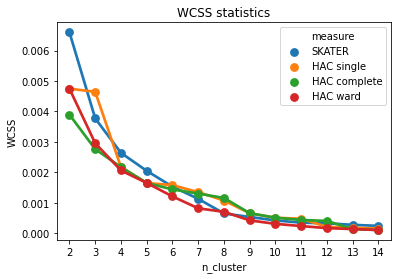

In [8]:
methods=['SKATER','HAC']
linkages=['single', 'complete', 'ward']

dfWCSS=pd.DataFrame()
spanning_forest_kwds = dict(
                            dissimilarity=skm.euclidean_distances,
                            affinity=None,
                            reduction=np.sum,
                            center=np.mean,
                            verbose=0
                            )

for m, method in enumerate (methods):
    WCSS=[]
    n_cluster=[]
    label=[]
    for n_cls_ in range(2, 15):
        if m==0:
            model = Skater(
                gdf=gdfCls, w=w_rook, attrs_name=['State_wtd'], n_clusters=n_cls_, floor=-np.inf, trace=False, 
                islands='ignore', spanning_forest_kwds=spanning_forest_kwds
            )
            model.solve()
            cluster_label=np.array(model.labels_)
            WCSS.append(WCSS_score(gdfCls['State_wtd'],cluster_label)) 
            n_cluster.append(len(np.unique(cluster_label)))
            label.append(method)

        else:
            for linkage_ in linkages:
                cluster_HAC = AgglomerativeClustering(n_clusters=n_cls_,affinity='euclidean', 
                                                      connectivity = w_rook.full()[0],
                                                      linkage=linkage_).fit(gdfCls[['State_wtd']])
                cluster_label=np.array(cluster_HAC.labels_)
                WCSS.append(WCSS_score(gdfCls['State_wtd'],cluster_label)) 
                n_cluster.append(len(np.unique(cluster_label)))
                label.append(method+" "+linkage_)
    dfTemp=pd.DataFrame({'measure':label, 'n_cluster':n_cluster, 'WCSS':WCSS})
    dfWCSS=pd.concat([dfWCSS,dfTemp], axis=0)
sns.pointplot(x='n_cluster',y='WCSS', hue='measure', data=dfWCSS, markers='o', dodge=0.0001).set(
    title='WCSS statistics');

In [9]:
# 2nd derivative of the WCSS for each model
dfWCSS.pivot(columns='measure', index='n_cluster', values='WCSS').diff().diff()

measure    HAC complete  HAC single  HAC ward        SKATER
n_cluster                                                  
2                   NaN         NaN       NaN           NaN
3                   NaN         NaN       NaN           NaN
4              0.000543   -0.002366  0.000898  1.692166e-03
5              0.000070    0.001950  0.000485  5.427104e-04
6              0.000307    0.000447 -0.000033  6.950255e-05
7              0.000077   -0.000154  0.000050  1.215578e-04
8             -0.000008   -0.000049  0.000276 -8.138395e-05
9             -0.000357   -0.000141 -0.000164  3.653940e-04
10             0.000353    0.000269  0.000165  4.274568e-07
11             0.000076    0.000116  0.000042  4.173545e-05
12             0.000040   -0.000235  0.000006  5.151563e-05
13            -0.000235    0.000237  0.000034 -3.056603e-05
14             0.000237    0.000004  0.000002  1.912818e-05

In [10]:
n_cls_=9  #optimal number of clusters
methods=['SKATER','HAC']
linkages=['single', 'complete', 'ward']
dfCls=pd.DataFrame()
spanning_forest_kwds = dict(
                            dissimilarity=skm.euclidean_distances,
                            affinity=None,
                            reduction=np.sum,
                            center=np.mean,
                            verbose=0
                            )
for m, method in enumerate(methods):
    if m==0:
        model = Skater(
            gdf=gdfCls, w=w_rook, attrs_name=['State_wtd'], n_clusters=n_cls_, floor=-np.inf, trace=False, 
            islands='ignore', spanning_forest_kwds=spanning_forest_kwds
        )
        model.solve()
        cluster_label=np.array(model.labels_, dtype='object')
        dfCls[method]=cluster_label
    else:
        for linkage_ in linkages:
            cluster_HAC = AgglomerativeClustering(n_clusters=n_cls_,affinity='euclidean', 
                                                  connectivity = w_rook.full()[0],
                                                  linkage=linkage_).fit(gdfCls[['State_wtd']])
            cluster_label=np.array(cluster_HAC.labels_, dtype='object')
            dfCls[method+"_"+linkage_]=cluster_label


C:\Python310\lib\site-packages\spopt\region\skater.py:537: OptimizeWarning: By default, the graph is disconnected! Counting islands towards the remaining 7 clusters.
  model.fit(
C:\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:549: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
C:\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:549: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
C:\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:279: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


In [11]:
gdfCluster=pd.concat([gdfCls,dfCls], axis=1)
gdfCluster.head()

cls_0                                           geometry  State_wtd  \
0      Acre  MULTIPOLYGON (((-68.88297 -11.01937, -68.88607...  -0.097149   
1   Alagoas  POLYGON ((-35.46317 -8.82467, -35.46457 -8.828...  -0.114044   
2  Amazonas  MULTIPOLYGON (((-58.49827 -0.83437, -58.49417 ...  -0.099747   
3     Bahia  MULTIPOLYGON (((-38.71177 -17.96617, -38.70687...  -0.120071   
4     Ceara  MULTIPOLYGON (((-40.42827 -2.81117, -40.42397 ...  -0.094499   

  SKATER HAC_single HAC_complete HAC_ward  
0      0          8            6        1  
1      1          4            1        2  
2      0          8            6        1  
3      1          4            1        2  
4      0          2            2        6

C:\Python310\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


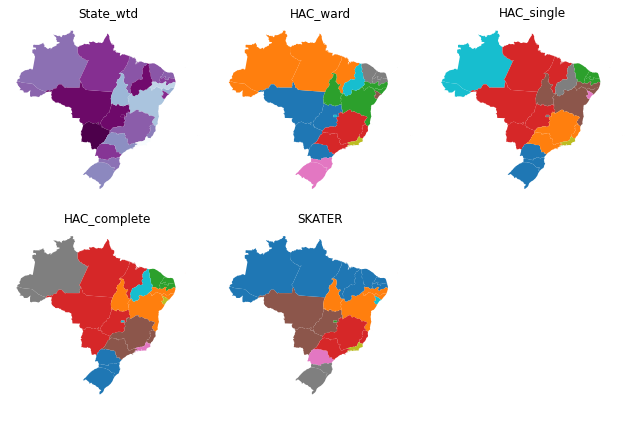

In [12]:
columns=['State_wtd', 'HAC_ward', 'HAC_single', 'HAC_complete', 'SKATER']

fig,axs=plt.subplots(2,3,figsize=(3*3,3*2),sharex=True, sharey=True)
for i, c in enumerate(columns):
    if i ==0:
        gdfCluster.plot(column=c,cmap='BuPu',legend=False, ax=axs[0,0])
    else:
        gdfCluster.plot(column=c,cmap='tab10',legend=False, ax=axs[int(i/3),int(i%3)])
    axs[int(i/3),int(i%3)].set_title(c,fontsize=12)
    axs[int(i/3),int(i%3)].xaxis.set_tick_params(labelbottom=False)
    axs[int(i/3),int(i%3)].yaxis.set_tick_params(labelleft=False)
    axs[int(i/3),int(i%3)].set_xticks([])
    axs[int(i/3),int(i%3)].set_yticks([])

sns.despine(left=True, bottom=True, right=True)
plt.tight_layout()
plt.show()

In [13]:
for c in columns[1:]:
    print(c)
    display(gdfCluster.groupby(c).size().max())

HAC_ward


4

HAC_single


5

HAC_complete


5

SKATER


8

#### Update the territory variable and vehicle weights in training and test data

In [14]:
sel_method='HAC_ward'
# map veh_wtd from nnet to the data
train_terr=train.merge(veh_wtd, how='left').merge(gdfCluster[['cls_0',sel_method]], how='left').rename(
    columns={sel_method:'territory_cls'})
test_terr=test.merge(veh_wtd, how='left').merge(gdfCluster[['cls_0',sel_method]], how='left').rename(
    columns={sel_method:'territory_cls'})

In [15]:
train_terr.to_csv('data/model_train_terr.csv')
test_terr.to_csv('data/model_test_terr.csv')

In [1]:
#test_terr[test_terr['VehGroup_wtd'].isna()]